# Titanic Survival Prediction.

### Import data from Kaggle from the API:

In [60]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "yasserh/titanic-dataset",
    "Titanic-Dataset.csv",
)

In [61]:
#essential packages
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore') #ignore warnings

### Lets see what the data looks like first.

In [62]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
display(df.describe(include='object'))
display(df.describe())
print("There are no duplicates in the data. GOOD" if df.duplicated().sum()==0 else "There are duplicates in the data. BAD")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,G6,S
freq,1,577,7,4,644


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are no duplicates in the data. GOOD


#### Do we see something ?

There might be some outilers based on the previous data description:
- 75% of the data has age < 38 and with a mean = 29.69, so the ones with 80 (and near) are a potential outliers.
- Same reasoning with Fare column, we have a max = 512 that represents whealthy instances (near max) and can be considered outliers in this data.
- also in SibSp and Parch, this columns describe that large famillies are rare and can be outliers.

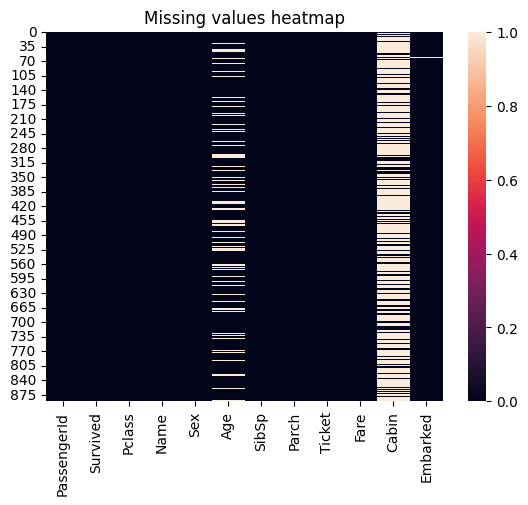

In [64]:
sns.heatmap(df.isna())
plt.title("Missing values heatmap")
plt.show()

In [65]:
#percentage of missing values in Age and Cabin column
print(f"Age: {df.Age.isna().mean()*100:.2f} % misses. \nCabin: {df.Cabin.isna().mean()*100:.2f} % misses. \nEmbarked: {df.Embarked.isna().mean()*100:.2f} % misses.")

Age: 19.87 % misses. 
Cabin: 77.10 % misses. 
Embarked: 0.22 % misses.


We can consider droping the columns Cabin, but it has valuable data that the models can use.

### Preprocessing and data cleaning:

As we saw, the data that we using has missing values and has non-numerical values, so we should change that in a way the models can understand and analyse.

So lets start by filling the missing values.

#### Filling Age:

<u>The question is</u> how can we fill the missing valus, with medians? means?  or maybe some ML algo like interpolate or KNN impute that uses neighbors value to deduce the missing one ?

First let's analyse the column Age: 

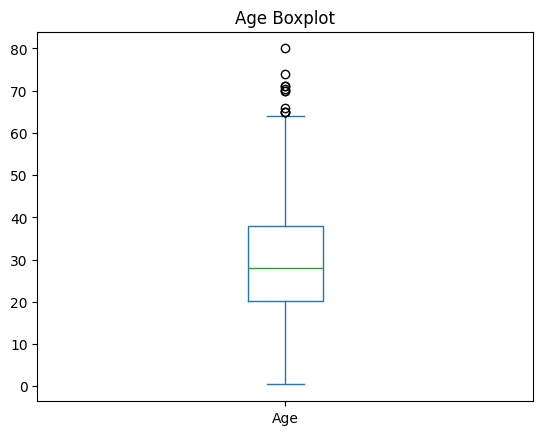

In [66]:
df.Age.plot(kind='box')
plt.title('Age Boxplot')
plt.show()

Hmmm, the median is a bit closer to the 1st quantil and we have some outliers towards the upper end; Maybe it's skewed-right ? Let's see the histogram and the skew value to be sure.

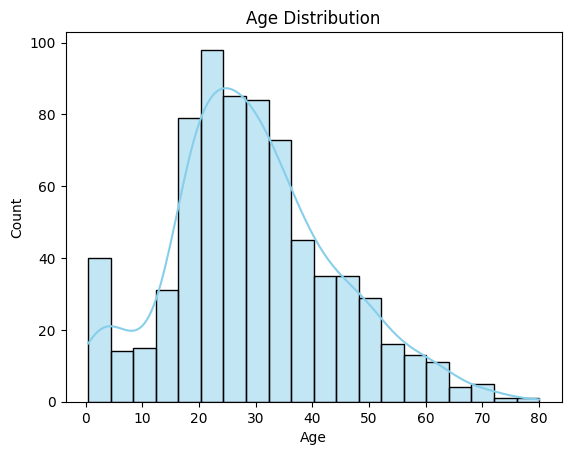

The skewed value of the Age: 0.38910778230082704
And finally, the mean > median > mode, so the Age distributin is skewed-right


In [67]:
sns.histplot(df.Age, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.show()

print(f"The skewed value of the Age: {df.Age.skew()}")

comp_symb = ">" if df.Age.mean() > df.Age.median() > df.Age.mode().values[0] else "<"
skewed_direction = "right" if comp_symb == ">" else "left"
print(f"And finally, the mean {comp_symb} median {comp_symb} mode, so the Age distributin is skewed-{skewed_direction}")


Now we are sure that the Age distribution of this data is skewed-right, then we can fill the missing values with the `median` since its robust versus the outliers causing this skewness.

In [68]:
# fill the missing values of Age with the median
df['Age'] = df['Age'].fillna(df['Age'].median())
print(f"missing values percentage: {float(df.Age.isna().mean()) * 100} %\n")
display(df.describe())

missing values percentage: 0.0 %



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check what else is to be filled.

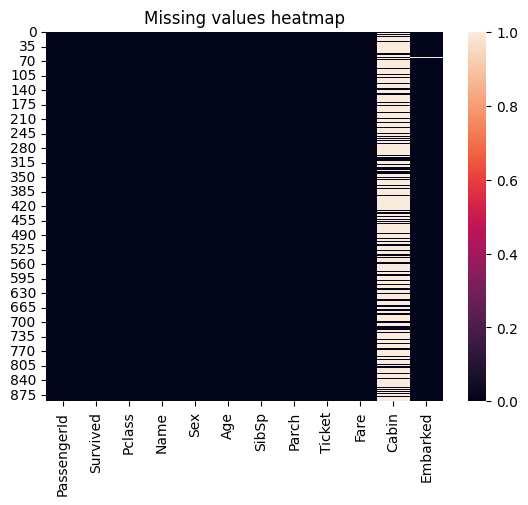

In [69]:
sns.heatmap(df.isna())
plt.title("Missing values heatmap")
plt.show()

#### Filling Cabin:

In [70]:
print(f"Cabin has {float(df["Cabin"].isna().mean()*100)} missing values.")
df.head()

Cabin has 77.10437710437711 missing values.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So we can just drop it.

In [71]:
df = df.drop(columns=["Cabin"], axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Lets also drop Name andPassengerId columns since they have a 100% unicity (no duplicates), and by logic these informations about the features is irrelevant.

Same thing with the Ticket column.

Note: just because a column has 0% duplicates (all values are unique) doesn't automatically mean it should be dropped. Exampl : timestamps are unique, they can help track trends or be transformed into useful features. But in our case, we can just drop them.

In [72]:
df = df.drop(columns=["Name", "Ticket", "PassengerId"], axis=1)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### !! We still have to deal the non-numerical columns.

Let's start with the Sex.

(1: male, 0: female)

In [73]:
# this is a commun transformation when we get columns like Sex, we just use the one-hot encoding using get_dummies() pandas method

df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True).astype(int) # change boolean type of get_dumies() into binary using astype(int) method
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [74]:
display(df.isna().sum())
df.info()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


We still have two missing values in Embarked columns of type Object. Best value to fill with is the commun one.

In [75]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# then we change to one-hot encoded
encoded_cols = pd.get_dummies(df["Embarked"], prefix="Embarked_").astype(int)

#drop it and replace with the one-hot encoded
df = df.drop(columns=["Embarked"])
df = df.join(encoded_cols)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked__C  891 non-null    int64  
 8   Embarked__Q  891 non-null    int64  
 9   Embarked__S  891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


No non-numerical and missing values.

All good to start modeling now. (TODO after, deal with outliers (can use zscore method from scipy.stats)) 